<a href="https://colab.research.google.com/github/pesadaum/sign-language-classification/blob/main/trabalho_pratico_pds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Trabalho prático - [ECAI44] Processamento digital de sinais </h1>
<h2> Detecção de gestos em LIBRAS com processamento digital de imagem </h2>

<hr>

# Bibliotecas e setup inicial

## Bibliotecas

In [ ]:
import cv2
import os
import string
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy import fftpack, ndimage
from matplotlib.colors import LogNorm
from tensorflow.keras import layers

rc = {'image.cmap': 'binary'}

plt.rcParams.update(rc)

## Acesso aos arquivos do Drive

Nota: Os arquivos utilizados estão no Drive de alefdeoliveirasantos@gmail.com. Caso tente re-executar o projeto, os arquivos utilizados não serão encontrados, pois estão em: <link>


In [ ]:
from google.colab import drive

drive.mount('/content/drive')


f_path = '/content/drive/MyDrive/trabalho_pratico_pds/'

Mounted at /content/drive


# Aplicação de LPF e Gaussinan Blur para remoção de ruído

## Grayscale e poluição da imagem

No processamento digital de sinais e imagens é frequente com poluição e ruidos do sinal, aqui é simulado quando esses ruídos são aplicados na imagem, o que pode comprometer a leitura do processo. Para um melhor processamento da imagem sempre se deve aplicar a escala de cinza, para normalizar o vetor das cores RGB do espectro de cores e facilitar o seu processamento.

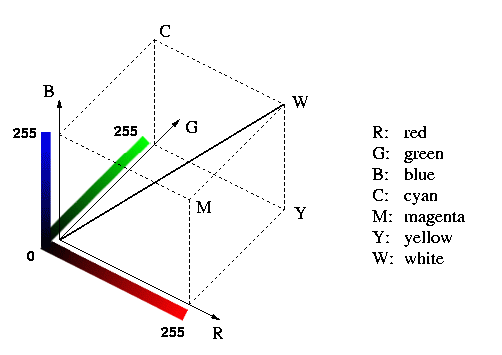

In [ ]:
#Aqui definimos uma imagem assim como ela pode ser poluída
#fname: nome do arquivo da imagem
#noise_amout: porcentagem de ruído

def get_clean_and_dirty_imgs(fname, noise_ammount):

    img_file = f_path + fname                   # caminho da imagem
    img = cv2.imread(img_file)                  # ler a imagem a partir do caminho
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # refletir para a escala de cinza

    clean = img.copy() # retorno da imagem cinza limpa

    noise = np.zeros_like(img)                        # cria matriz de mesmo tamanho de zeros
    cv2.randu(noise, 0, 256)                          # passa por referência e cria ruído a partir da imagem
    noisy_img = img + np.array(noise_ammount*noise)   # aplica ruído na imagem

    dirty = noisy_img.copy()                          #retorno da imagem poluída

    return (clean, dirty)                             #retorno da função

In [ ]:
img, noisy_img = get_clean_and_dirty_imgs('numero_1.PNG', 0.9)

## Gaussian blur:

$$ G(x_i,y_i) = \frac{1}{\sqrt{2\pi\sigma^2}} \cdot e^{\dfrac{-x_i^2+y_i^2}{2\sigma^2}}$$

## Ideal

$$ LPF(x_i,y_i) = \begin{cases} 1 \quad \text{para a região delimitada em torno do círculo de raio } r \\
0 \quad \text{caso contrário} \end{cases}$$

## Mostrando os resultados

A função a seguir aplica o LPF(Low pass filter), para isso necessita o uso da FFT, passando para o espectro das frequências o que torna possível a aplicação do filtro.

In [ ]:
def low_pass_fft(img, threshold, return_fft=False):
    fft_img = fftpack.fft2(img)

    x, y = fft_img.shape # forma da imagem

    # Abaixo de um threshold especificado é retornado 0
    fft_img[int(x*threshold):int(x*(1-threshold))] = 0      # aplica o fitro multiplicando as altas frequências no espectro por 0
    fft_img[:, int(y*threshold):int(y*(1-threshold))] = 0

    new_img = fftpack.ifft2(fft_img).real  # retorno da imagem


    if return_fft:
        return (new_img, fft_img)

    return new_img



Aqui se obtem o retorno da função do low pass puro, na linha seguinte tem-se o low pass aplicado com o gaussianbluer que é disponibilizado pela biblioteca `ndimage`, a ideia é comparar as duas funções e mostrar que apenas o low pass não pode ser o suficiente



In [ ]:
new_img = low_pass_fft(img, 0.1)            # imagem com low pass puro aplicado
im_blur = ndimage.gaussian_filter(img, 1)   #imagem com low pass gaussinao aplicado

É perseptivel que a imagem

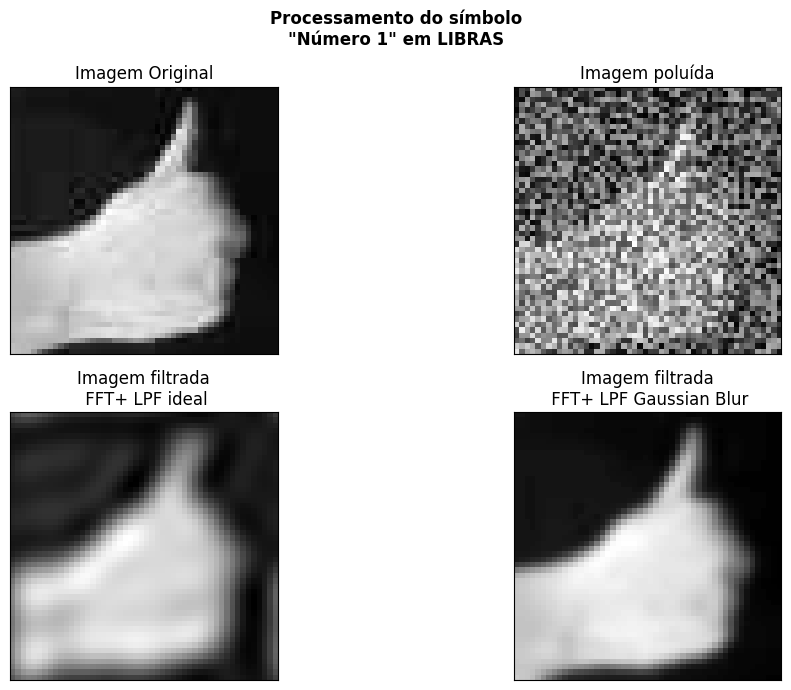

In [ ]:
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 7))

ax[0, 0].imshow(img)
ax[0, 1].imshow(noisy_img)
ax[1, 0].imshow(new_img)
ax[1, 1].imshow(im_blur)

titles = ['Imagem Original',
          'Imagem poluída',
          'Imagem filtrada\n FFT+ LPF ideal',
          'Imagem filtrada\n FFT+ LPF Gaussian Blur']

for i, t in enumerate(titles):
    ax.flat[i].set(title=t, xticks=[], yticks=[])

f.suptitle('Processamento do símbolo\n"Número 1" em LIBRAS', fontweight='bold')

f.tight_layout()



##Segmentação
O procesoo de segmentação permite identificar e separar regiões de interesse na imagem. Isso ajuda a direcionar a atenção da rede neural que será utilizada para áreas relevantes, melhorando a precisão e eficiência do processo de reconhecimento. A segmentação binária fornece informações sobre a localização precisa dos objetos na imagem, permitindo mais facildade para que a rede neural extraia características e padrões relevantes para realizar tarefas específicas.

In [ ]:
def segmentate(img, return_threshold=False):
    img_back = cv2.normalize(img, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8U)
    ret, img_bin = cv2.threshold(img_back, 0, 255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    if return_threshold:
        return (ret, img_bin)

    return img_bin



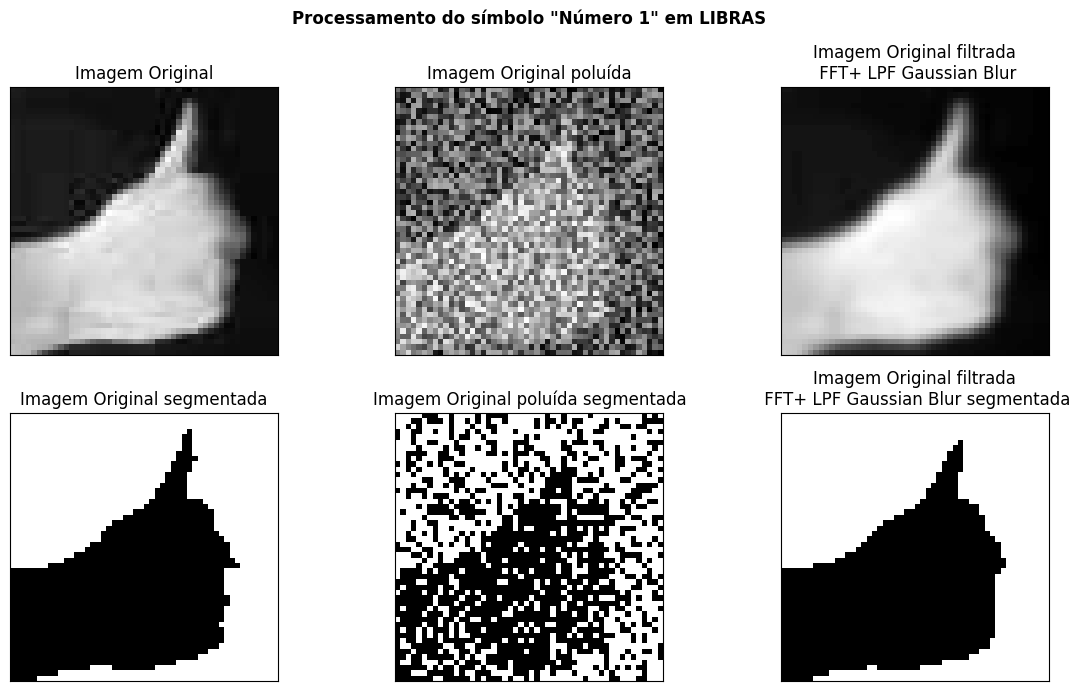

In [ ]:
f, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 7))

img, noisy_img = get_clean_and_dirty_imgs('numero_1.PNG', 0.9)

ax[0, 0].imshow(img)
ax[0, 1].imshow(noisy_img)
ax[0, 2].imshow(im_blur)

seg_clean_img = segmentate(img)
seg_noisy_img = segmentate(noisy_img)
seg_filtered_img = segmentate(im_blur)

ax[1, 0].imshow(seg_clean_img)
ax[1, 1].imshow(seg_noisy_img)
ax[1, 2].imshow(seg_filtered_img)

titles = ['Imagem Original',
          'Imagem Original poluída',
          'Imagem Original filtrada\n FFT+ LPF Gaussian Blur',
          'Imagem Original segmentada',
          'Imagem Original poluída segmentada',
          'Imagem Original filtrada\n FFT+ LPF Gaussian Blur segmentada']

for i, t in enumerate(titles):
    ax.flat[i].set(title=t, xticks=[], yticks=[])

f.suptitle('Processamento do símbolo "Número 1" em LIBRAS', fontweight='bold')

f.tight_layout()



## Diferenciação dos pixels

In [ ]:
_, fft_clean_img = low_pass_fft(img, 0.1, True)
_, fft_noisy_img = low_pass_fft(noisy_img, 0.1, True)

new_img = low_pass_fft(img, 0.1)
im_blur = ndimage.gaussian_filter(img, 1)

# Aplicação do HPF para detecção de borda

In [ ]:
img = cv2.imread(f_path + 'mao.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Redimensionamento da imagem original
scale_percent = 30 # percent of original size
w = int(img.shape[1] * scale_percent / 100)
h = int(img.shape[0] * scale_percent / 100)
dim = (w, h)

# resize image
img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

O filtro passas-altas permite que as bordas da imagem sejam detectadas, ele funciona detectando as mudanças bruscas de intensidade nos pixels adjacentes e destacando essas transições abruptas, que geralmente correspondem às bordas da imagem.


## HPF

$$ HPF(x_i,y_i) = \begin{cases} 0 \quad \text{para a região delimitada em torno do círculo de raio } r \\
1 \quad \text{caso contrário} \end{cases}$$

<ipython-input-12-31f5ab5b37e9>:21: RuntimeWarning: divide by zero encountered in log
  fshift_mask_mag = 2000 * np.log(cv2.magnitude(fshift[:, :, 0], fshift[:, :, 1])) # calcula o espectro de magnitude com a mascara


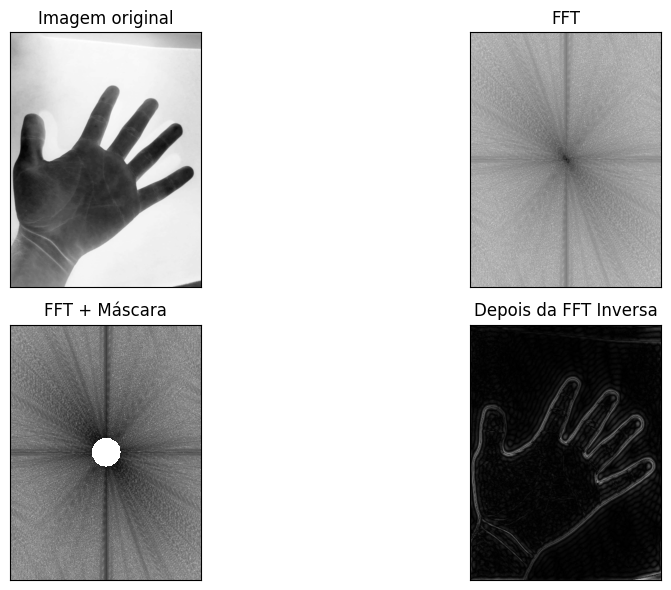

In [ ]:


dft = cv2.dft(np.float64(img), flags=cv2.DFT_COMPLEX_OUTPUT) # calcula a transformada de fourier
dft_shift = np.fft.fftshift(dft) # centraliza a transformada

magnitude_spectrum = 20 * np.log(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1])) # calcula o espectro de magnitude

rows, cols = img.shape # pega o tamanho da imagem
crow, ccol = int(rows / 2), int(cols / 2)  # encontra o centro da imagem

# cria uma mascara para o filtro passa-alta
mask = np.ones((rows, cols, 2), np.uint8)
r = 25
center = [crow, ccol]
x, y = np.ogrid[:rows, :cols]
mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= r*r
mask[mask_area] = 0

# aplica a mascara
fshift = dft_shift * mask


fshift_mask_mag = 2000 * np.log(cv2.magnitude(fshift[:, :, 0], fshift[:, :, 1])) # calcula o espectro de magnitude com a mascara

# aplica a transformada inversa de fourier
f_ishift = np.fft.ifftshift(fshift)
img_back = cv2.idft(f_ishift)
img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])

f, ax = plt.subplots(ncols=2, nrows = 2, figsize=(12,6))


ax[0,0].imshow(img)
ax[0,1].imshow(magnitude_spectrum)
ax[1,0].imshow(fshift_mask_mag)
ax[1,1].imshow(img_back, cmap='gray')


for a in ax.flat:
    a.set(
        xticks=[],
        yticks=[],
    )

ax[0,0].set_title('Imagem original')
ax[0,1].set_title('FFT')
ax[1,0].set_title('FFT + Máscara')
ax[1,1].set_title('Depois da FFT Inversa')


f.tight_layout()

plt.show()

# Resultados

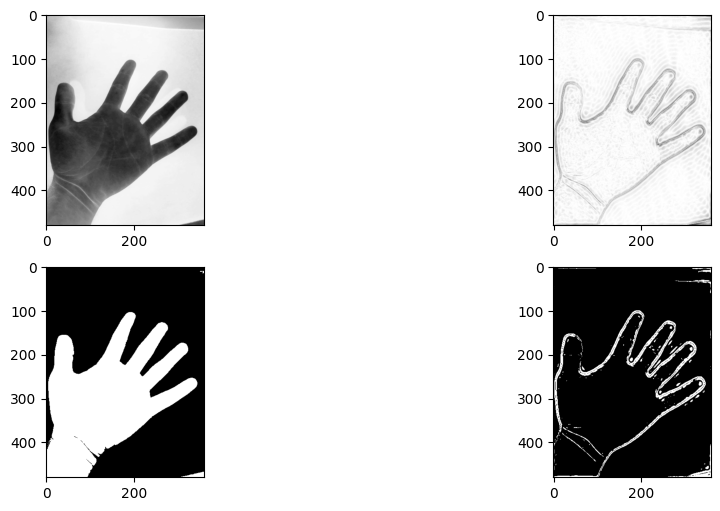

In [ ]:
img_bin = segmentate(img)
img_bin_fft = segmentate(img_back)

f, ax = plt.subplots(nrows= 2, ncols=2, figsize=(12, 6))


ax[0, 0].imshow(img)
ax[1, 0].imshow(img_bin)

ax[0, 1].imshow(img_back)
ax[1, 1].imshow(img_bin_fft)




# Classificação com rede neural

## Preparação dos dados

In [ ]:
def load_data(path):
    df = pd.read_csv(path)
    y = np.array([label if label < 9
                  else label-1 for label in df['label']])
    df = df.drop('label', axis=1)
    x = np.array([df.iloc[i].to_numpy().reshape((28, 28))
                  for i in range(len(df))]).astype(float)
    x = np.expand_dims(x, axis=3)
    y = pd.get_dummies(y).values

    return x, y



In [ ]:
def rescale_train_data(X_train, X_test):
    X_train = X_train.reshape(X_train.shape + (1,))
    X_test = X_test.reshape(X_test.shape + (1, ))

    X_train = X_train / 255.
    X_test = X_test / 255.

    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)

    return (X_train, X_test)


## Construção do modelo

In [ ]:
def build_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=32,
                            kernel_size=(3, 3),
                            activation='relu',
                            input_shape=(28, 28, 1)), # Equivale a colocar a input layer com 728 direto
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(filters=64,
                            kernel_size=(3, 3),
                            activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(24, activation='softmax') # Camada de saída com 24 neurônios
    ])

    return model



## Avaliação dos resultados

In [ ]:
X_train, y_train = load_data(f_path + 'sign_mnist_train.csv')
X_test, y_test = load_data(f_path + 'sign_mnist_test.csv')

X_train, X_test = rescale_train_data(X_train, X_test) # necessario para manter todas as imagens do mesmo tamanho


In [ ]:
model = build_model()

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)



model.fit(X_train, y_train, epochs=3)

Epoch 1/3
858/858 [==============================] - 37s 40ms/step - loss: 0.8167 - accuracy: 0.7822
Epoch 2/3
858/858 [==============================] - 34s 39ms/step - loss: 0.1441 - accuracy: 0.9640
Epoch 3/3
858/858 [==============================] - 33s 39ms/step - loss: 0.0851 - accuracy: 0.9772


In [ ]:
model.evaluate(X_test, y_test)

225/225 [==============================] - 4s 14ms/step - loss: 0.7903 - accuracy: 0.7863


[0.7903355360031128, 0.7862520813941956]

1/1 [==============================] - 0s 37ms/step
24 24


,Letra,Resultado
23,y,1.0


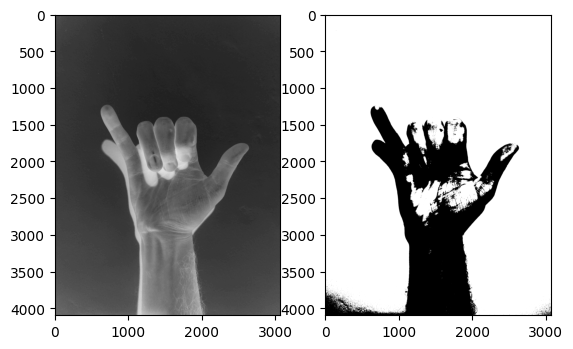

In [ ]:
def show_prediction(fname):
    letters = list(string.ascii_lowercase[:26].replace('j', '').replace('z', '')) # forma de transformar vetor binário em a-z

    clean_img, _ = get_clean_and_dirty_imgs(fname, 1)
    resized = cv2.resize(clean_img, (28, 28), interpolation = cv2.INTER_AREA)
    test_img = np.expand_dims(resized, axis=0)

    predict = model.predict(test_img)
    predict_df = pd.DataFrame.from_records([letters, predict.flat, ]).T
    predict_df = predict_df[predict_df[1] > 0]
    predict_df.columns = ['Letra', 'Resultado']

    print(len(letters), len(predict.flat))


    return (clean_img, predict_df)

img, predict_df = show_prediction('mao-y.jpg')

f, ax = plt.subplots(ncols=2)

seg_img = segmentate(img)

ax[0].imshow(img)
ax[1].imshow(seg_img)

predict_df

![https://www.researchgate.net/publication/328396430/figure/fig1/AS:683619848830976@1539999081795/The-26-letters-and-10-digits-of-American-Sign-Language-ASL.jpg](https://www.researchgate.net/publication/328396430/figure/fig1/AS:683619848830976@1539999081795/The-26-letters-and-10-digits-of-American-Sign-Language-ASL.jpg)



In [ ]:
m = f_path + 'model.pkl'

file = open(m, 'wb')
pkl.dump(m, file)
file.close()